<a href="https://colab.research.google.com/github/xanderdavies/toy_model_grokking/blob/main/toy_grok_dd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Model for Grokking and Double Descent

Xander Davies, Lauro Langosco, and David Krueger

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

We model the learning of *patterns*, or particular input-output function learned during the training process. Pattern $i$ has predictiveness $\text{pred}_i(t)$ at timestep $t$ (i.e., portion of training set they know), parameterized by a maximum predictiveness $\gamma_i$, inflection point $b_i$, and learning speed $\alpha_i$:
\begin{equation}
\text{pred}_i(t) = \frac{\gamma_i}{1 + e^{-\alpha_i(x - b_i)}}
\end{equation}

Features then generalize according to:
\begin{equation}
\text{gen}_i(t) = g_i \cdot \text{pred}_i(t)
\end{equation}

We model double descent & grokking learning dynamics through three patterns (or groups of patterns with equivalent properties):
1. *Fast-to-learn, well-generalizing patterns (heuristics).* In double descent, we model these patterns as being able to explain 70% of the data ($\gamma_1 = .7$) and generalizing perfectly ($g_1=1$). In grokking, we say there aren't any such heuristics ($\gamma_1=0$). 
2. *Medium-to-learn, poorly-generalizing patterns (overfitting).* This category of pattern includes memorization, so has $\gamma_2 = 1$ and $g_2=0$ in both double descent and grokking.
3. *Slow-to-learn, well-generalizing patterns, which are __favored__.* In both cases, we say $g_3=1$, but in double descent we say these patterns can only explain 20% of the data ($\gamma_1 = .2$) and in grokking we say it can explain all of the data ($\gamma_1 = 1$). These patterns (in both cases) have the special property of being *preferred*, which means they are used in any case where they are predictive (as opposed to this being decided randomely in cases where multiple patterns overlap).

We define accuracy $\text{acc}(t)$ at timestep $t$ per:

\begin{align}
\text{acc}(t) &= \text{pred}_1(t) \cup \text{pred}_2(t) \cup \text{pred}_3(t) \\
&= \text{pred}_1(t) + \text{pred}_2(t) + \text{pred}_3(t) - \left(\text{pred}_1(t) \text{pred}_2(t) + \text{pred}_1(t) \text{pred}_3(t) + \text{pred}_2(t) \text{pred}_3(t)\right) + \text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) 
\end{align}

We define pattern usage $u_i(t)$ as the proportion of examples seen by $p_i$ at timestep $t$, which is upperbounded by $\text{pred}_i(t)$:
\begin{align}
u_1(t) &= \text{pred}_1(t) - \text{pred}_1(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_2(t) &= \text{pred}_2(t) - \text{pred}_2(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_3(t) &= \text{pred}_3(t)
\end{align}

*Note that $u_1(t) + u_2(t) + u_3(t) \leq 1$, $\forall t \geq 0, \text{pred}_i \leq 1$.*

We then say our model generalizes according to each pattern's generality $g_i$ applied to each usage $u_i(t)$:

\begin{align}
\text{gen}(t) = g_1 u_1(t) + g_2 u_2(t) + g_3 u_3(t)
\end{align}

In [4]:
def pred_i(p, t):
  return p["gamma"] / (1 + np.exp(-p["alpha"]*(t - p["b"])))

def acc(p_1, p_2, p_3, t):
  preds = [pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)]
  return preds[0] + preds[1] + preds[2] - preds[0]*preds[1] - preds[0] * preds[2] - preds[1] * preds[2] + preds[0] * preds[1] * preds[2]

def gen(p_1, p_2, p_3, t):
  preds = [pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)]
  u_1 = preds[0] - preds[2]*preds[0] - preds[0]*preds[1]/2 + preds[0]*preds[1]*preds[2]/2
  u_2 = preds[1] - preds[2]*preds[1] - preds[0]*preds[1]/2 + preds[0]*preds[1]*preds[2]/2
  u_3 = preds[2]
  return u_1*p_1["g"] + u_2*p_2["g"] + u_3*p_3["g"]

In [5]:
#@title Double Descent <> Grokking

#@markdown *To transition between double descent and grokking, lower the predictiveness of heuristics, and increase the predictiviness of the slow well-generalizing patterns.*

import ipywidgets as widgets
grokking = False
STEPS = 300

p_1 = {
    "gamma": 0. if grokking else 0.7,
    "alpha": .15,
    "b": 30,
    "g": 1,
}

p_2 = {
    "gamma": 1,
    "alpha": .15,
    "b": 50,
    "g": 0,
}

p_3 = {
    "gamma": 1. if grokking else 0.2,
    "alpha": .05,
    "b": 200,
    "g": 1,
}

@widgets.interact(heuristics=(0., 1.), slow_good=(0., 1.))
def plot_grok_dd(heuristics=p_1["gamma"], slow_good=p_3["gamma"]):
  p_1["gamma"] = heuristics
  p_3["gamma"] = slow_good

  x = np.arange(0, STEPS)
  fig, axs = plt.subplots(1, 2, figsize=(20,8))
  fig.canvas.header_visible = False

  # feature learning
  heuristics, = axs[0].plot(x, pred_i(p_1, x), label="heuristics")
  memorization, = axs[0].plot(x, pred_i(p_2, x), label="overfitting")
  slow, = axs[0].plot(x, pred_i(p_3, x), label="slow \nwell-generalizing")
  axs[0].set_xlabel("epochs")
  axs[0].set_ylabel("Predictiveness")
  axs[0].legend()
  axs[0].set_title("Pattern Learning")

  # accuracy
  train, = axs[1].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
  test, = axs[1].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
  axs[1].set_xlabel("epochs")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_title("Accuracy")
  axs[1].legend()

interactive(children=(FloatSlider(value=0.7, description='heuristics', max=1.0), FloatSlider(value=0.2, descri…

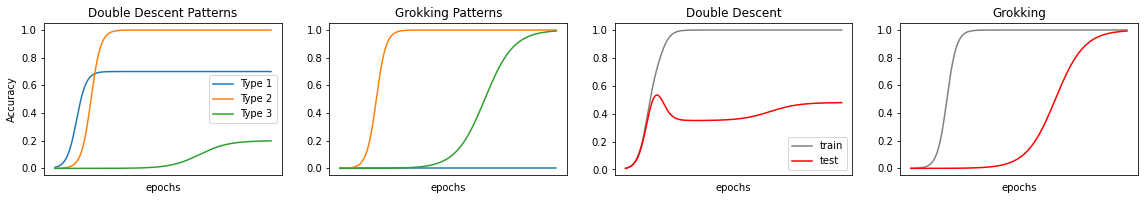

In [3]:
#@title Figure in paper

STEPS = 300

p_1 = {
    "gamma": 0.7,
    "alpha": .15,
    "b": 30,
    "g": 1,
}

p_2 = {
    "gamma": 1,
    "alpha": .15,
    "b": 50,
    "g": 0,
}

p_3 = {
    "gamma": 0.2,
    "alpha": .05,
    "b": 200,
    "g": 1,
}

x = np.arange(0, STEPS)
fig, axs = plt.subplots(1, 4, figsize=(28*.7,4*.7))

## Double Descent
# feature learning
heuristics, = axs[0].plot(x, pred_i(p_1, x), label="Type 1")
memorization, = axs[0].plot(x, pred_i(p_2, x), label="Type 2")
slow, = axs[0].plot(x, pred_i(p_3, x), label="Type 3")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].set_xticks([])
axs[0].set_title("Double Descent Patterns")

# accuracy
train, = axs[2].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
test, = axs[2].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
# axs[2].set_ylabel("Accuracy")
axs[2].set_xlabel("epochs")
axs[2].set_xticks([])
axs[2].set_title("Double Descent")
axs[2].legend()

## GROK
p_1["gamma"] = 0.
p_3["gamma"] = 1.# feature learning
heuristics, = axs[1].plot(x, pred_i(p_1, x), label="Type 1")
memorization, = axs[1].plot(x, pred_i(p_2, x), label="Type 2")
slow, = axs[1].plot(x, pred_i(p_3, x), label="Type 3")
# axs[1].set_ylabel("Predictiveness")
# axs[1].legend(loc="lower left")
axs[1].set_xlabel("epochs")
axs[1].set_xticks([])
axs[1].set_title("Grokking Patterns")

# accuracy
train, = axs[3].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
test, = axs[3].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
# axs[3].set_ylabel("Accuracy")
axs[3].set_xlabel("epochs")
axs[3].set_xticks([])
axs[3].set_title("Grokking")
# axs[3].legend(loc="lower right");

plt.savefig("toy_model.pdf")

# [OLD] To be cut

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

Consider two different patterns, $p_1$ and $p_2$. Both patterns are learned according to $\text{final_predictiveness} \cdot \text{sigmoid}(\frac{x}{\alpha} + b)$, where $\alpha, b$ control the speed at which the pattern is learned by the network. Say $p_1$ is a fast-to-learn feature with $\alpha = 5$ and $b = 10$, and $p_2$ is a slow-to-learn feature with $\alpha = 50$ and $b = 10$. Both features are equally predictive w.r.t the training data. But say that $p_1$ happens to be a *poorly-generalizing feature* (chance performance in the test set), and $p_2$ happens to be a *well-generalizing feature* (equivalent to training performance).



For **grokking**, try `p_1_predictiveness` = 1, `p_1_generalization` = 0, `p_1_speed` = 5, `p_2_predictiveness` = 1, `p_2_generalization` = 1, `p_2_speed` = 50, and `steps` = 1000. \\

For **epoch-wise double descent**, try `p_1_predictiveness` = 1, `p_1_generalization` = .6, `p_1_speed` = 5, `p_2_predictiveness` = 1, `p_2_generalization` = .8, `p_2_speed` = 7, and `steps` = 100. Also, turn off log scale.

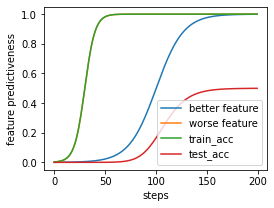

In [ ]:
#@title Select Pattern Parameters
# These look like double descent:
# p_1_predictiveness = 1 #@param {type:"number"}
# p_1_generalization = 1 #@param {type:"number"}
# p_1_slope = .075 #@param {type:"number"}
# p_1_inflect = 70 #@param {type:"integer"}

# p_2_predictiveness = 1 #@param {type:"number"}
# p_2_generalization = 0.5 #@param {type:"number"}
# p_2_slope = .2 #@param {type:"number"}
# p_2_inflect = 100 #@param {type:"integer"}
# STEPS = 100 #@param {type:"integer"}
# LOG_SCALE = False #@param {type:"boolean"}

p_1_predictiveness = 1 #@param {type:"number"}
p_1_generalization = 1 #@param {type:"number"}
p_1_slope = .075 #@param {type:"number"}
p_1_inflect = 100 #@param {type:"integer"}

p_2_predictiveness = 1 #@param {type:"number"}
p_2_generalization = 0 #@param {type:"number"}
p_2_slope = .2 #@param {type:"number"}
p_2_inflect = 30 #@param {type:"integer"}
STEPS = 100 #@param {type:"integer"}
LOG_SCALE = False #@param {type:"boolean"}

# fast 
p_1 = {
    "alpha": p_1_slope,
    "b": p_1_inflect,
    "predictiveness": p_1_predictiveness,
    "generalization": p_1_generalization
}

# slow
p_2 = {
    "alpha": p_2_slope,
    "b": p_2_inflect,
    "predictiveness": p_2_predictiveness,
    "generalization": p_2_generalization
}

x = np.arange(0, STEPS*2)

y_2 = p_2["predictiveness"] * 1/(1 + np.exp(-p_2["alpha"]*(x - p_2["b"])))
y_2_gen = y_2 * p_2["generalization"] 
# y_2_gen = p_2["generalization"] 


y_1 = p_1["predictiveness"] * 1./(1 + np.exp(-p_1["alpha"]*(x- p_1["b"])))
y_1_gen = y_1 * p_1["generalization"] 
# y_1_gen = p_1["generalization"] 

train_acc = y_1 + y_2 - y_1 * y_2
ratio = y_2 / (y_1 + y_2)
# test_acc = train_acc * (ratio * y_2_gen + (1 - ratio) * y_1_gen)
test_acc = (ratio * y_2_gen + (1 - ratio) * y_1_gen) - (ratio * y_2_gen * (1 - ratio) * y_1_gen)

plt.figure(figsize=(4,3))
plt.plot(x, y_1, label="better feature")
plt.plot(x, y_2, label="worse feature")
#plt.plot(x, y_1/y_2, label="fast/slow feature")
# plt.plot(x, ratio, label="ratio")
plt.plot(x, train_acc, label="train_acc")
plt.plot(x, test_acc, label="test_acc")



#plt.ylim(.4, .6)
#plt.xlim(70,150)
if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

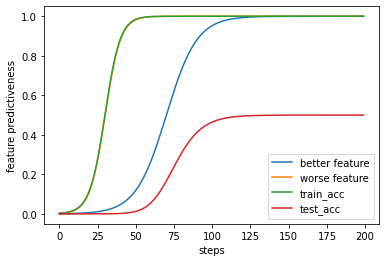

In [ ]:
#@title Select Pattern Parameters
# These look like double descent:
p_1_predictiveness = 1 #@param {type:"number"}
p_1_generalization = 1 #@param {type:"number"}
p_1_slope = .1 #@param {type:"number"}
p_1_inflect = 70 #@param {type:"integer"}

p_2_predictiveness = 1 #@param {type:"number"}
p_2_generalization = 0 #@param {type:"number"}
p_2_slope = .2 #@param {type:"number"}
p_2_inflect = 30 #@param {type:"integer"}
STEPS = 100 #@param {type:"integer"}
LOG_SCALE = False #@param {type:"boolean"}

# fast 
p_1 = {
    "alpha": p_1_slope,
    "b": p_1_inflect,
    "predictiveness": p_1_predictiveness,
    "generalization": p_1_generalization
}

# slow
p_2 = {
    "alpha": p_2_slope,
    "b": p_2_inflect,
    "predictiveness": p_2_predictiveness,
    "generalization": p_2_generalization
}

x = np.arange(0, STEPS*2)

y_2 = p_2["predictiveness"] * 1/(1 + np.exp(-p_2["alpha"]*(x - p_2["b"])))
y_2_gen = y_2 * p_2["generalization"] 
# y_2_gen = p_2["generalization"] 


y_1 = p_1["predictiveness"] * 1./(1 + np.exp(-p_1["alpha"]*(x- p_1["b"])))
y_1_gen = y_1 * p_1["generalization"] 
# y_1_gen = p_1["generalization"] 

ratio = y_2 / (y_1 + y_2)
train_acc = y_1 + y_2 - y_1 * y_2
test_acc = train_acc * (ratio * y_2_gen + (1 - ratio) * y_1_gen)

plt.plot(x, y_1, label="better feature")
plt.plot(x, y_2, label="worse feature")
#plt.plot(x, y_1/y_2, label="fast/slow feature")
# plt.plot(x, ratio, label="ratio")
plt.plot(x, train_acc, label="train_acc")
plt.plot(x, test_acc, label="test_acc")



#plt.ylim(.4, .6)
#plt.xlim(70,150)
if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

Say, though, that due to regularization pressures, our slower feature is preffered, which leads to the *unlearning* of features redundant with the slower features as they develop. Accordingly, our second feature development is represented as $$\text{development}_1 = \text{max}(0, \text{pred}_1 - \text{pred}_2)$$

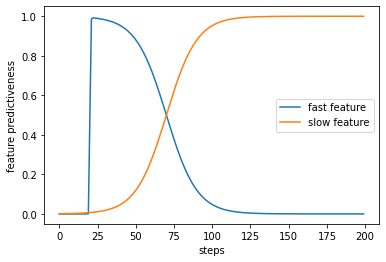

In [ ]:
y_1_minus_2 = p_1["predictiveness"] * 1/(1 + np.e ** -(x/p_1["alpha"] - p_1["b"])) - y_2
y_1_minus_2[y_1_minus_2 < 0] = 0
y_1_minus_2_gen = y_1_minus_2 * p_1["generalization"]
plt.plot(x, y_1_minus_2, label="fast feature")
plt.plot(x, y_2, label="slow feature")

if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

Our training accuracy is calculated as the sum of our two features. *To Do, sketch*. $$ \text{acc}_{train}^t = \text{development}_1 + \text{development}_2$$ Our test accuracy is calculated by a (normalized) sum of pattern generalization, weighted by how in use a given feature is, defined as: $$\text{acc}^t_{test} = \frac{1}{\text{development}_1 + \text{development}_2} \left( \text{development}_1^t * \text{gen}_1^t + \text{development}_2^t * \text{gen}_2^t \right)$$

This is basically saying that we use an optimal allocation of patterns during training, but use a random allocation during test. *I think this is kind of reasonable.*

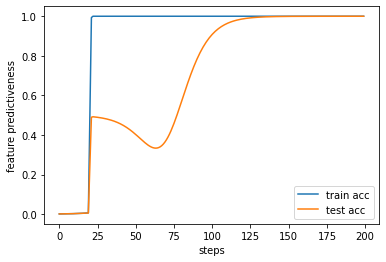

In [ ]:
train_acc = y_1_minus_2 + y_2
test_acc = (y_1_minus_2*y_1_minus_2_gen + y_2*y_2_gen) / (y_1_minus_2 + y_2)

# plt.plot(y_1_minus_2, label="fast feature")
# plt.plot(y_2, label="slow feature")
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")

if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

# [OLD] To be cut

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

Consider two different patterns, $p_1$ and $p_2$. Both patterns are learned according to $\text{final_predictiveness} \cdot \text{sigmoid}(\frac{x}{\alpha} + b)$, where $\alpha, b$ control the speed at which the pattern is learned by the network. Say $p_1$ is a fast-to-learn feature with $\alpha = 5$ and $b = 10$, and $p_2$ is a slow-to-learn feature with $\alpha = 50$ and $b = 10$. Both features are equally predictive w.r.t the training data. But say that $p_1$ happens to be a *poorly-generalizing feature* (chance performance in the test set), and $p_2$ happens to be a *well-generalizing feature* (equivalent to training performance).



For **grokking**, try `p_1_predictiveness` = 1, `p_1_generalization` = 0, `p_1_speed` = 5, `p_2_predictiveness` = 1, `p_2_generalization` = 1, `p_2_speed` = 50, and `steps` = 1000. \\

For **epoch-wise double descent**, try `p_1_predictiveness` = 1, `p_1_generalization` = .6, `p_1_speed` = 5, `p_2_predictiveness` = 1, `p_2_generalization` = .8, `p_2_speed` = 7, and `steps` = 100. Also, turn off log scale.

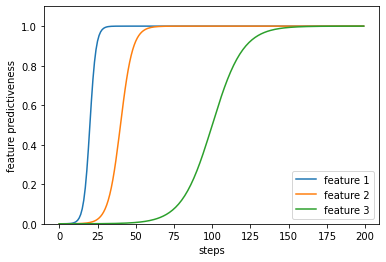

In [ ]:
#@title Select Pattern Parameters
p_1_predictiveness = 1 #@param {type:"number"}
p_1_generalization = .8 #@param {type:"number"}
p_1_speed = 2 #@param {type:"integer"}

p_2_predictiveness = 1 #@param {type:"number"}
p_2_generalization = 0 #@param {type:"number"}
p_2_speed = 4 #@param {type:"integer"}


p_3_predictiveness = 1 #@param {type:"number"}
p_3_generalization = 1 #@param {type:"number"}
p_3_speed = 10 #@param {type:"integer"}

STEPS = 100 #@param {type:"integer"}
LOG_SCALE = False #@param {type:"boolean"}

p_1 = {
    "alpha": p_1_speed,
    "b": 10,
    "predictiveness": p_1_predictiveness,
    "generalization": p_1_generalization
}
p_2 = {
    "alpha": p_2_speed,
    "b": 10,
    "predictiveness": p_2_predictiveness,
    "generalization": p_2_generalization
}
p_3 = {
    "alpha": p_3_speed,
    "b": 10,
    "predictiveness": p_3_predictiveness,
    "generalization": p_3_generalization
}

x = np.arange(0, STEPS*2)

y_1 = p_1["predictiveness"] * 1/(1 + np.e ** -(x/p_1["alpha"] - p_1["b"]))
y_1_gen = y_1 * p_1["generalization"] 

y_2 = p_2["predictiveness"] * 1/(1 + np.e ** -(x/p_2["alpha"] - p_2["b"]))
y_2_gen = y_2 * p_2["generalization"] 

y_3 = p_3["predictiveness"] * 1/(1 + np.e ** -(x/p_3["alpha"] - p_3["b"]))
y_3_gen = y_3 * p_3["generalization"] 

plt.plot(x, y_1, label="feature 1")
plt.plot(x, y_2, label="feature 2")
plt.plot(x, y_3, label="feature 3")

plt.ylim(0, 1.1)
if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

Say, though, that due to regularization pressures, our slower features are always preffered, which leads to the *unlearning* of features redundant with the slower features as they develop. Accordingly, our second and third features are developed as:
\begin{align} 
\text{development}_1 &= \text{max}(0, \text{pred}_1 - \text{pred}_2 - \text{pred}_3) \\
\text{development}_2 &= \text{max}(0, \text{pred}_2 - \text{pred}_3) 
\end{align}

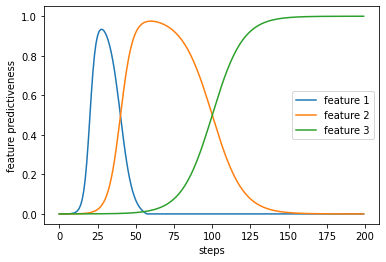

In [ ]:
y_1_dev = y_1 - y_2 - y_3
y_1_dev[y_1_dev < 0] = 0
y_1_dev_gen = y_1_dev * p_1["generalization"]
y_2_dev = y_2 - y_3
y_2_dev[y_2_dev < 0] = 0
y_2_dev_gen = y_2_dev * p_2["generalization"]

plt.plot(x, y_1_dev, label="feature 1")
plt.plot(x, y_2_dev, label="feature 2")
plt.plot(x, y_3, label="feature 3")

if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

Our training accuracy is calculated as the sum of our two features. *To Do, sketch*. $$ \text{acc}_{train}^t = \text{development}_1 + \text{development}_2$$ Our test accuracy is calculated by a (normalized) sum of pattern generalization, weighted by how in use a given feature is, defined as: $$\text{acc}^t_{test} = \frac{1}{\text{development}_1 + \text{development}_2} \left( \text{development}_1^t * \text{gen}_1^t + \text{development}_2^t * \text{gen}_2^t \right)$$

This is basically saying that we use an optimal allocation of patterns during training, but use a random allocation during test. *I think this is kind of reasonable.*

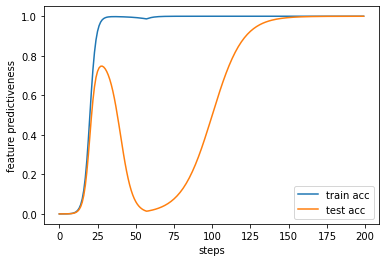

In [ ]:
train_acc = y_1_dev + y_2_dev + y_3
test_acc = y_1_dev * p_1["generalization"] + y_2_dev * p_2["generalization"] + y_3 * p_3["generalization"]

# plt.plot(y_1_minus_2, label="fast feature")
# plt.plot(y_2, label="slow feature")
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")

if LOG_SCALE:
  plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

# [OLD] To be cut

To validate the model, we train a MLP on synthetic data with two different patterns of known $\text{final_pred_i}$ and $

# [OLD] To be cut

At a given timestep $t$, training accuracy is determined according to: $$\text{acc}_{\text{train}} = 1 - (1 - \text{pred}_1^t)(1 - \text{pred}_2^t)$$

That is, we correctly classify training samples iff one of our patterns correctly classifies. Our test accuracy is determined by calculating what percent of the time $p_1$ and $p_2$ were used for classifying, and assuming that the same ratio is used at test time as well (randomely select between patterns in cases when both correctly classify:
\begin{align}
\text{acc}_{\text{test}} = &\text{chance} \cdot (1 - \text{pred}_1^t)(1 - \text{pred}_2^t) + \text{gen}_1 \cdot \text{pred}_1^t(1 - \text{pred}_2^t) + \\ &\text{gen}_2 \cdot (1 - \text{pred}_1^t)\text{pred}_2 + \frac{\text{gen}_1 + \text{gen}_2}{2} \cdot (1 - \text{pred}_1^t)(1 - \text{pred}_2^t)
\end{align}

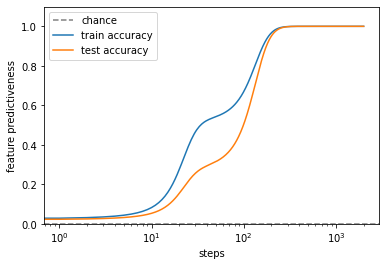

In [ ]:
def train_acc(pred_1, pred_2, t):
    return 1 - (1 - pred_1)*(1 - pred_2)
    # equiv to y_1*(1 - y_2) + (1 - y_1)*y_2 + y_1*y_2

def test_acc(pred_1, pred_2, t): 
    use_either = pred_1*pred_2 
    use_p1 = pred_1*(1 - pred_2)
    use_p2 = (1 - pred_1)*pred_2
    use_none = (1 - pred_1)*(1 - pred_2)
    return CHANCE * use_none + p_1["generalization"] * use_p1 + p_2["generalization"] * use_p2 + use_either*(p_2["generalization"]) # use_either*(p_1["generalization"] + p_2["generalization"])/2

t_acc, v_acc = [], []
for t in range(2000):
  pred_1 = CHANCE + (p_1["predictiveness"] - CHANCE) * 1/(1 + np.e ** -(t/p_1["alpha"] - p_1["b"]))
  pred_2 = CHANCE + (p_2["predictiveness"] - CHANCE) * 1/(1 + np.e ** -(t/p_2["alpha"] - p_2["b"]))
  
  t_acc.append(train_acc(pred_1, pred_2, t))
  v_acc.append(test_acc(pred_1, pred_2, t))
  # p_1["predictiveness"] = pred_1*pred_2/(pred_1*pred_2 + pred_1*(1 - pred_2))
# blue curve would be unlearned if we reduce the predictiveness wrt use_either

x = np.arange(0, 2000)
plt.xscale("log")
y_2 = CHANCE + (p_2["predictiveness"] - CHANCE) * 1/(1 + np.e ** -(x/p_2["alpha"] - p_2["b"]))
y_1 = CHANCE + (p_1["predictiveness"] - CHANCE) * 1/(1 + np.e ** -(x/p_1["alpha"] - p_1["b"]))
plt.xlabel("steps")
plt.ylim(0, 1.1)
plt.ylabel("feature predictiveness")
plt.axhline(CHANCE, color="grey", linestyle="--", label="chance")
# plt.plot(x, y_1, label="fast feature")
# plt.plot(x, y_2, label="slow feature")
plt.plot(t_acc, label="train accuracy")
plt.plot(v_acc, label="test accuracy")
plt.legend()
plt.show()

### Modeling Routing

Rather than assuming optimal routing, we now add a learnable routing parameter $w$, which controls allocation between $p_1$ and $p_2$. 

### Take 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

Consider two different patterns, $p_1$ and $p_2$. Both patterns are learned according to $\text{final_predictiveness} \cdot \text{sigmoid}(\frac{x}{\alpha} + b)$, where $\alpha, b$ control the speed at which the pattern is learned by the network. Say $p_1$ is a fast-to-learn feature with $\alpha = 5$ and $b = 10$, and $p_2$ is a slow-to-learn feature with $\alpha = 50$ and $b = 10$. Both features are equally predictive w.r.t the training data, and (say) succesfully explain half the data. But say that $p_1$ happens to be a *poorly-generalizing feature* (chance performance in the test set), and $p_2$ happens to be a *well-generalizing feature* (equivalent to training performance).



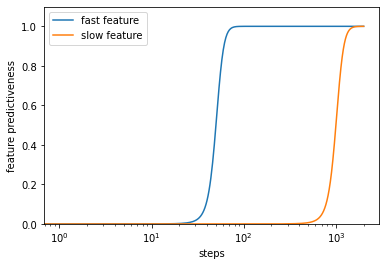

In [ ]:
# memorization
p_1 = {
    "alpha": 5,
    "b": 10,
    "predictiveness": 1,
    "generalization": 0.2
    ,
    "decay_penalty": 5,
}

# slow, good gen
p_2 = {
    "alpha": 100,
    "b": 10,
    "predictiveness": 1,
    "generalization": 1,
    "decay_penalty": 1
}

x = np.arange(0, 2000)

y_1 = p_1["predictiveness"]* 1/(1 + np.e ** -(x/p_1["alpha"] - p_1["b"]))
y_2 = p_2["predictiveness"]* 1/(1 + np.e ** -(x/p_2["alpha"] - p_2["b"]))
plt.plot(x, y_1, label="fast feature")
plt.plot(x, y_2, label="slow feature")

plt.ylim(0, 1.1)
plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

At a given timestep $t$, training accuracy is determined according to: $$\text{acc}_{\text{train}} = 1 - (1 - \text{pred}_1^t)(1 - \text{pred}_2^t)$$

That is, we correctly classify training samples iff one of our patterns correctly classifies. Our test accuracy is determined by calculating what percent of the time $p_1$ and $p_2$ were used for classifying, and assuming that the same ratio is used at test time as well (randomely select between patterns in cases when both correctly classify:

\begin{align}
\text{acc}_{\text{test}} = &0 \cdot (1 - \text{pred}_1^t)(1 - \text{pred}_2^t) + \text{gen}_1 \cdot \text{pred}_1^t(1 - \text{pred}_2^t) + \text{gen}_2 \cdot (1 - \text{pred}_1^t)\text{pred}_2 + \\ & (r \cdot \text{gen}_1 + (1 - r) \cdot \text{gen}_2) \cdot (1 - \text{pred}_1^t)(1 - \text{pred}_2^t)
\end{align}

$r$ controls which pattern is used when both patterns correctly classify; we model weight decay as modulating $r$, encouraging a preferred pattern to be used when both correctly classify (which we can think of as unlearning the bit of the unpreferred feature responsible for correctly classifying that sample).

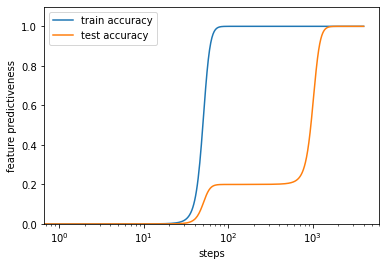

In [ ]:
def train_acc(pred_1, pred_2, t):
    return 1 - (1 - pred_1)*(1 - pred_2)
    # equiv to y_1*(1 - y_2) + (1 - y_1)*y_2 + y_1*y_2

def test_acc(pred_1, pred_2, t, routing): 
    use_either = pred_1*pred_2 
    use_p1 = pred_1*(1 - pred_2)
    use_p2 = (1 - pred_1)*pred_2
    use_none = (1 - pred_1)*(1 - pred_2)
    return 0 * use_none + p_1["generalization"] * use_p1 + p_2["generalization"] * use_p2 + use_either*(routing * p_1["generalization"] + (1 - routing) * p_2["generalization"])

t_acc, v_acc = [], []
routing = 0.5
for t in range(4000):
  pred_1 = p_1["predictiveness"] * 1/(1 + np.e ** -(t/p_1["alpha"] - p_1["b"]))
  pred_2 = p_2["predictiveness"] * 1/(1 + np.e ** -(t/p_2["alpha"] - p_2["b"]))

  acc = train_acc(pred_1, pred_2, t)
  t_acc.append(acc)
  v_acc.append(test_acc(pred_1, pred_2, t, routing))

  # WEIGHT DECAY removes redundant bits from use_either
  if acc > 0.99:
    routing *= 0.99

x = np.arange(0, 4000)
plt.xscale("log")
plt.xlabel("steps")
plt.ylim(0, 1.1)
plt.ylabel("feature predictiveness")
# plt.axhline(CHANCE, color="grey", linestyle="--", label="chance")
# plt.plot(x, y_1, label="fast feature")
# plt.plot(x, y_2, label="slow feature")
plt.plot(t_acc, label="train accuracy")
plt.plot(v_acc, label="test accuracy")
plt.legend()
plt.show()

### Double Descent

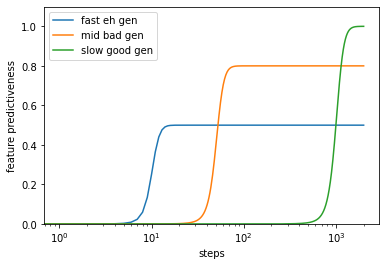

In [ ]:
p_0 = {
    "alpha": 1,
    "b": 10,
    "predictiveness": .5,
    "generalization": .5,
    "decay_penalty": 5,
}

# memorization
p_1 = {
    "alpha": 5,
    "b": 10,
    "predictiveness": .8,
    "generalization": 0,
    "decay_penalty": 5,
}

# slow, good gen
p_2 = {
    "alpha": 100,
    "b": 10,
    "predictiveness": 1,
    "generalization": 1,
    "decay_penalty": 1
}

x = np.arange(0, 2000)

y_0 = p_0["predictiveness"]* 1/(1 + np.e ** -(x/p_0["alpha"] - p_0["b"]))
y_1 = p_1["predictiveness"]* 1/(1 + np.e ** -(x/p_1["alpha"] - p_1["b"]))
y_2 = p_2["predictiveness"]* 1/(1 + np.e ** -(x/p_2["alpha"] - p_2["b"]))
plt.plot(x, y_0, label="fast eh gen")
plt.plot(x, y_1, label="mid bad gen")
plt.plot(x, y_2, label="slow good gen")

plt.ylim(0, 1.1)
plt.xscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
plt.legend()
plt.show()

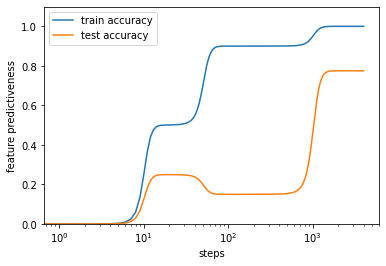

In [ ]:
def train_acc(pred_0, pred_1, pred_2, t):
    return 1 - (1 - pred_0)*(1 - pred_1)*(1 - pred_2)

def test_acc(pred_0, red_1, pred_2, t, routing): 
    use_any = pred_1*pred_2 

    use_p0 = pred_0*(1 - pred_1)*(1 - pred_2)
    use_p1 = pred_1*(1 - pred_0)*(1 - pred_2)
    use_p2 = pred_2*(1 - pred_0)*(1 - pred_1)

    use_p01 = pred_0*pred_1*(1 - pred_2)
    use_p02 = pred_0*pred_2*(1 - pred_1)
    use_p12 = pred_1*pred_2*(1 - pred_0)

    use_none = (1 - pred_0)*(1 - pred_1)*(1 - pred_2)

    # weighted sum for output
    out = 0 * use_none 

    out += p_0["generalization"] * use_p0
    out += p_1["generalization"] * use_p1
    out += p_2["generalization"] * use_p2

    out += (p_0["generalization"] + p_1["generalization"])/2 * use_p01
    out += (p_0["generalization"] + p_2["generalization"])/2 * use_p02
    out += (p_1["generalization"] + p_2["generalization"])/2 * use_p12

    out += (p_0["generalization"] + p_1["generalization"] + p_2["generalization"])/3 * use_any

    return out

t_acc, v_acc = [], []
routing = 0.5
for t in range(4000):
  pred_0 = p_0["predictiveness"] * 1/(1 + np.e ** -(t/p_0["alpha"] - p_0["b"]))
  pred_1 = p_1["predictiveness"] * 1/(1 + np.e ** -(t/p_1["alpha"] - p_1["b"]))
  pred_2 = p_2["predictiveness"] * 1/(1 + np.e ** -(t/p_2["alpha"] - p_2["b"]))

  acc = train_acc(pred_0, pred_1, pred_2, t)
  t_acc.append(acc)
  v_acc.append(test_acc(pred_0, pred_1, pred_2, t, routing))

  # # WEIGHT DECAY removes redundant bits from use_either
  # if acc > 0.99:
  #   routing *= (1 - pred_1)

x = np.arange(0, 4000)
plt.xscale("log")
plt.xlabel("steps")
plt.ylim(0, 1.1)
plt.ylabel("feature predictiveness")
# plt.axhline(CHANCE, color="grey", linestyle="--", label="chance")
# plt.plot(x, y_1, label="fast feature")
# plt.plot(x, y_2, label="slow feature")
plt.plot(t_acc, label="train accuracy")
plt.plot(v_acc, label="test accuracy")
plt.legend()
plt.show()

At every timestep $t$, assume we take a step which maxamizes 

\begin{align}
L &= \text{optimality} - \text{cost} \\
&= 
\end{align}

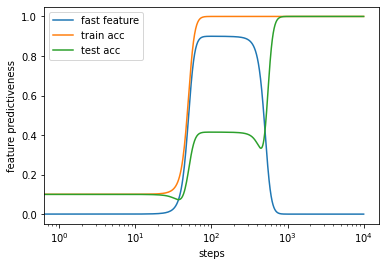

In [ ]:
train_acc = []
test_acc = []

step_f1, step_f2 = 0, 0
f1_development, f2_development = [], []
for i in range(STEPS):

  # decide update location
  # delta_perf_1 = y_1[step_f1 + 1] - y_1[step_f1]
  # delta_perf_2 = y_2[step_f2 + 1] - y_2[step_f2]

  # if delta_perf_1 > delta_perf_2: 
  #   step_f1 += 2
  # else:
  #   step_f2 += 2
  step_f1 += 1; step_f2 += 1

  f1_development.append(y_1[step_f1])
  f2_development.append(y_2[step_f2])

  train_acc.append(y_1[step_f1] + y_2[step_f2])
  test_acc.append((y_1[step_f1]*y_1_gen[step_f1] + y_2[step_f2]*y_2_gen[step_f2]) / (y_1[step_f1] + y_2[step_f2]))

  # if y_1[step_f1] > y_2[step_f2]:
  #   train_acc.append(y_1[step_f1])
  #   test_acc.append(y_1_gen[step_f1])
  # else:
  #   train_acc.append(y_2[step_f1])
  #   test_acc.append(y_2_gen[step_f2])
  
  

plt.plot(f1_development, label="fast feature")
# plt.plot(f2_development, label="slow feature")
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")
# plt.plot(x, y_3, label="slow feature forgetting")

# plt.ylim(0, 1.1)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("feature predictiveness")
# plt.axhline(CHANCE, color="grey", linestyle="--", label="chance")
plt.legend()
plt.show()